## Project 2: MD

# 1. Characterize your model’s behavior at N/V = 0.5 in the NVT ensemble:
# Above what temperature is your system “hot”? How do you know?
## According to my data with the standard LJ systems running at temps kT = 0.25 to kT to 2.0, in .25 increments, it really seems like the KE per particle skyrockets at around kT = 1.0 and above. We see this because our potential energy becomes minimized whereas the kinetic energy becomes maximized at these temperatures.
# Below what temperature is your system “frozen”? How do you know?
## The other way around applies. At around kT = 0.25 and below, which I did not measure, we see that our system is progressively storing more and more potential energy as we lower kT. This is reflected in the kinetic energy graph, where energy fluctuations are so small, meaning, on average, the KE of a particle is minimal. 
# How does the system’s total energy, potential energy, kinetic energy, heat capacity, and structure vary from frozen to too hot?
## We see that the systems total energy reflects the most applicable energy. If we have a frozen system, our total energy is mostly potential. If it's a very hot system, our total energy is mostly kinetic energy. Our heat capacity varies the most from ranges kT = 0.25 - 0.75. In the graph I included regarding the difference in heat capacity for different temps, we see that a phase transition occurs from 0.25 - 0.75, as the heat capacity beyond 0.75 remains relatively constant. As for structure, I included an RDF for various kT as well, ranging from 0.25 - 2.0. The lower the kT, the more likely a nearest neighbor will be within 1 to 1.3 r, due to the frozen nature of the system. We can even see that at lower kT, the 2nd peak is more prominent, indicating an ordered system structure. At higher kT, the first peak is significantly lower, and g(r) equilibrates to 1 faster as kT increases.
# 2. Characterize finite size effects:
# How small is too small to be correct? How large is too large to be practical?
## According to my data, it seems that increasing N only makes running simulations longer. I ran with several N, ranging from 1000 - 8000, and the results across all the simulations displayed that heat capacity increased as N increased, which is to be expected. Other than that, N had little to no impact on KE, TE, or PE, or even the structure really. The noise would be reduced on the RDF graph as N increases, but that's about it. With too small of N, the system would have a significantly different average energies however, so I think running too small of simulations is not a great idea in general, but hitting the sweetspot of being on the relaxed end of the exp/log curve with a large enough N, but not so much as to needlessly run forever.
# 3. Contrast your system with an ideal gas:
# How does the structure of your model vary with state, and how does it compare to particles with no interactions?
## Quite simply, there is zero potential when it comes to an ideal gas system. This means that the only thing affecting an ideal gas system is temperature, which obviously should increase the kinetic energy of the system, and only the kinetic energy. It is evident that it is essentially entirely random what the structure is of the system over time. Also, the heat capacity is also entirely random as well. Pressure increases linearly, scaling with kT. 
# Does the heat capacity of your system depend on state differently than an ideal gas?
## Yes, entirely. With an ideal gas, it is entirely random what the heat capacity of the system is.
# Can you derive or numerically determine an equation of state?
## Yes, but for an ideal gas system, it is not really necessary as it is a constant value. I used heat capacity to demonstrate this: Cv = 3/2R.
# Summarize your observations, challenges, and any revelations you had while working towards 1-3.. Which specific simulation and state point was your favorite (and why)?
## I had a lot of fun playing around with the parameters and observing correlations between kT, structure, and energy. My main struggles lied in figuring out autocorrelation functions, and I think I managed to bridge that gap by manipulating some criteria in my ACF in order to find the decorrelation time. I was able to yield meaningful independent sample sizes and find relaxation time as a result. My favorite simulation statepoint was easily kT = 0.25, and it's because I got to witness the phase transitions as I amped up the temperature via heat capacity. A big revelation I had was how neat flowerMD truly is. 

In [1]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import hoomd
import copy
import numpy as np

In [2]:
def rdf(snapshot, r_max, bin_width):
    positions = snapshot.particles.position
    box = snapshot.configuration.box
    Lx, Ly, Lz = box[0], box[1], box[2]
    N = len(positions)
    volume = Lx * Ly * Lz
    density = N / volume

    num_bins = int(r_max / bin_width)
    rdf_hist = np.zeros(num_bins)

    ## Loop through all unique particle pairs
    for i in range(N):
        for j in range(i + 1, N):
            dr = positions[i] - positions[j]

            ## Apply minimum image convention
            dr[0] -= Lx * np.round(dr[0] / Lx)
            dr[1] -= Ly * np.round(dr[1] / Ly)
            dr[2] -= Lz * np.round(dr[2] / Lz)

            r = np.linalg.norm(dr)
            if r < r_max:
                bin_index = int(r / bin_width)
                rdf_hist[bin_index] += 2  ## (i,j) and (j,i)

    ## Normalize RDF
    r = np.linspace(0.5 * bin_width, r_max - 0.5 * bin_width, num_bins)
    shell_volumes = (4/3) * np.pi * ((r + 0.5 * bin_width)**3 - (r - 0.5 * bin_width)**3)
    ideal_counts = density * shell_volumes * N
    g_r = rdf_hist / ideal_counts

    return r, g_r

In [3]:
def heat_cap(energies, T, N):
    E_mean = np.mean(np.array(energies))
    E2_mean = np.mean(np.array(energies)**2)
    Cv = (E2_mean - E_mean**2) / (T**2)
    Cv_per_particle = Cv / N
    return Cv_per_particle

In [4]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))
    acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    dt = np.where(acorr < 1/np.e)[0][0]  ## 1/e ≈ 0.37
    nsamples = len(array) // dt
    acorr = acorr[dt:nsamples]  ## truncated, not used further
    return nsamples, dt

In [5]:
## Add this new function for computing relaxation time (ACF integral)
def relaxation_time_from_acf(array, dt_real):
    ft = np.fft.rfft(array - np.average(array))
    acf = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    acf = acf[:len(array)]  ## keep all positive lags
    acf = acf[acf > 0]      ## only positive region
    return np.sum(acf) * dt_real

In [6]:
del simulation

NameError: name 'simulation' is not defined

In [7]:
dt = 0.005
epsilon = 1.0
sigma = 1.0
starting_density = 0.5
kTs = [0.25, 0.50, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
device = hoomd.device.CPU()
n_repeats = 3

heat_capacity_results = {kT: [] for kT in kTs}

for kT in kTs:
    print(f"\n--- Running kT = {kT} ---")

    for rep in range(n_repeats):
        print(f"  Repeat {rep + 1}")
        seed = np.random.randint(1, 1e5)

        simulation = hoomd.Simulation(device=device, seed=seed)

        a = 1 / (starting_density ** (1 / 3.0))
        num_replicas = 10
        N_particles = num_replicas ** 3
        grid_particles = freud.data.UnitCell([a, a, a, 0, 0, 0], [[0, 0, 0]]).generate_system(num_replicas)
        box_length = grid_particles[0].Lx

        frame = gsd.hoomd.Frame()
        frame.particles.N = N_particles
        frame.particles.position = grid_particles[1]
        frame.configuration.box = [box_length, box_length, box_length, 0, 0, 0]
        frame.particles.typeid = [0] * N_particles
        frame.particles.types = ['A']

        with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
            f.append(frame)

        simulation.create_state_from_gsd(filename='initial_state.gsd')

        integrator = hoomd.md.Integrator(dt=dt)
        nvt = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=kT, tau=dt * 100)
        integrator.methods.append(nvt)

        cell = hoomd.md.nlist.Cell(buffer=0.4)
        lj = hoomd.md.pair.LJ(nlist=cell)
        lj.params[('A', 'A')] = {"epsilon": epsilon, "sigma": sigma}
        lj.r_cut[('A', 'A')] = 2.5 * sigma
        integrator.forces.append(lj)
        simulation.operations.integrator = integrator

        simulation.run(10)
        simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)

        thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
        simulation.operations.computes.append(thermo)

        total_energy = []

        for step in range(10000):
            simulation.run(10)
            pe = thermo.potential_energy
            ke = thermo.kinetic_energy
            total_energy.append(pe + ke)

        Cv_per_particle = heat_cap(total_energy, kT, N_particles)
        heat_capacity_results[kT].append(Cv_per_particle)

    ## After all repeats
    cv_mean = np.mean(heat_capacity_results[kT])
    cv_std = np.std(heat_capacity_results[kT])
    print(f"kT = {kT:.2f} | Mean Cv = {cv_mean:.4f} ± {cv_std:.4f}")


--- Running kT = 0.25 ---
  Repeat 1


/home/eridanirojas/miniconda3/envs/project2/lib/python3.11/site-packages/hoomd/md/methods/methods.py:102: FutureWarning: NVT is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method with the desired thermostat from hoomd.md.methods.thermostats.
  warnings.warn(
*Warning*: Provided seed 99009 is larger than 65535. Truncating to 33473.


  Repeat 2
  Repeat 3
kT = 0.25 | Mean Cv = 1034.8641 ± 149.5756

--- Running kT = 0.5 ---
  Repeat 1
  Repeat 2
  Repeat 3


*Warning*: Provided seed 69459 is larger than 65535. Truncating to 3923.


kT = 0.50 | Mean Cv = 132.7638 ± 7.6794

--- Running kT = 0.75 ---
  Repeat 1


*Warning*: Provided seed 96053 is larger than 65535. Truncating to 30517.


  Repeat 2


*Warning*: Provided seed 78858 is larger than 65535. Truncating to 13322.


  Repeat 3
kT = 0.75 | Mean Cv = 22.6283 ± 0.3405

--- Running kT = 1.0 ---
  Repeat 1
  Repeat 2
  Repeat 3
kT = 1.00 | Mean Cv = 4.0517 ± 0.3013

--- Running kT = 1.25 ---
  Repeat 1
  Repeat 2
  Repeat 3
kT = 1.25 | Mean Cv = 2.7048 ± 0.2732

--- Running kT = 1.5 ---
  Repeat 1
  Repeat 2
  Repeat 3
kT = 1.50 | Mean Cv = 3.0846 ± 0.3906

--- Running kT = 1.75 ---
  Repeat 1
  Repeat 2
  Repeat 3
kT = 1.75 | Mean Cv = 3.3173 ± 0.2490

--- Running kT = 2.0 ---
  Repeat 1
  Repeat 2
  Repeat 3
kT = 2.00 | Mean Cv = 3.0570 ± 0.1704


In [8]:
potential_energy = {}
kinetic_energy = {}
total_energy = {}
snapshots = {}
heat_capacities = {}
dt = 0.005
epsilon = 1.0
sigma = 1.0
starting_density = 0.5
kTs = [0.25, 0.50, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
device = hoomd.device.CPU()
seed = np.random.randint(1,1e4)

for kT in kTs:
  print(kT)
  potential_energy[f"{kT}"] = []
  kinetic_energy[f"{kT}"] = []
  total_energy[f"{kT}"] = []
  snapshots[f"{kT}"] = []
  heat_capacities[f"{kT}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)

  ##a is the spacing between particles
  a = 1/(starting_density**(1/3.0))
  ##We want a number of particles N in our system.
  ##Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
  num_replicas = 10
  N_particles = num_replicas**3
  grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
  box_length = grid_particles[0].Lx

  frame = gsd.hoomd.Frame()
  frame.particles.N = N_particles
  frame.particles.position = grid_particles[1]
  frame.configuration.box = [box_length,box_length,box_length,0,0,0]

  ##Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
  ##in a coarse-grained simulation we can give them a simple name like A
  frame.particles.typeid = [0]*N_particles
  frame.particles.types = ['A']

  ##Finally, save our initial state:
  with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
      f.append(frame)

  simulation.create_state_from_gsd(filename='initial_state.gsd')

  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(), kT = kT , tau = dt*100)
  integrator.methods.append(nvt)

  cell = hoomd.md.nlist.Cell(buffer=0.4)

  ##Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma

  integrator.forces.append(lj)
  simulation.operations.integrator = integrator

  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(thermodynamic_properties, quantities=['potential_energy', 'kinetic_energy'])
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e3)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
      simulation.run(10)
      potential_energy[f"{kT}"].append(thermodynamic_properties.potential_energy)
      kinetic_energy[f"{kT}"].append(thermodynamic_properties.kinetic_energy)
      total_energy[f"{kT}"].append(thermodynamic_properties.kinetic_energy + thermodynamic_properties.potential_energy)
  snapshots[f"{kT}"] = simulation.state.get_snapshot()
  Cv_per_particle = heat_cap(total_energy[f"{kT}"], kT, N_particles)
  heat_capacities[f"{kT}"] = Cv_per_particle
  nsamples, dt_index = autocorr1D(potential_energy[f"{kT}"])
  dt_real = dt * 10  ## you're sampling energy every run(10)
    
  tau_relax = relaxation_time_from_acf(potential_energy[f"{kT}"], dt_real)
    
  print(f"kT = {kT:.2f} | Decorrelation time ≈ {dt_index * dt_real:.3f} time units")
  print(f"kT = {kT:.2f} | Estimated independent samples: {nsamples}")
  print(f"kT = {kT:.2f} | Relaxation time ≈ {tau_relax:.3f} time units")

0.25
Simulation.timestep  Simulation.tps 
       1000            3359.46249   
       2000            3211.99143   
       3000            2868.98310   
       4000            2858.05017   
       5000            1665.12488   
       6000            1540.04107   
       7000            2988.04781   
       8000            2972.25892   
       9000            1658.37479   
       10000           2891.10183   
       11000           1640.24057   
       12000           2898.55072   
       13000           1505.52024   
       14000           1645.94001   
       15000           2728.92662   
       16000           2831.96979   
       17000           1653.49991   
       18000           1412.65108   
       19000           2732.24044   
       20000           2880.00000   
       21000           2808.11232   
       22000           2743.90244   
       23000           1512.60504   
       24000           2717.39130   
       25000           1612.32533   
       26000           1629.54916

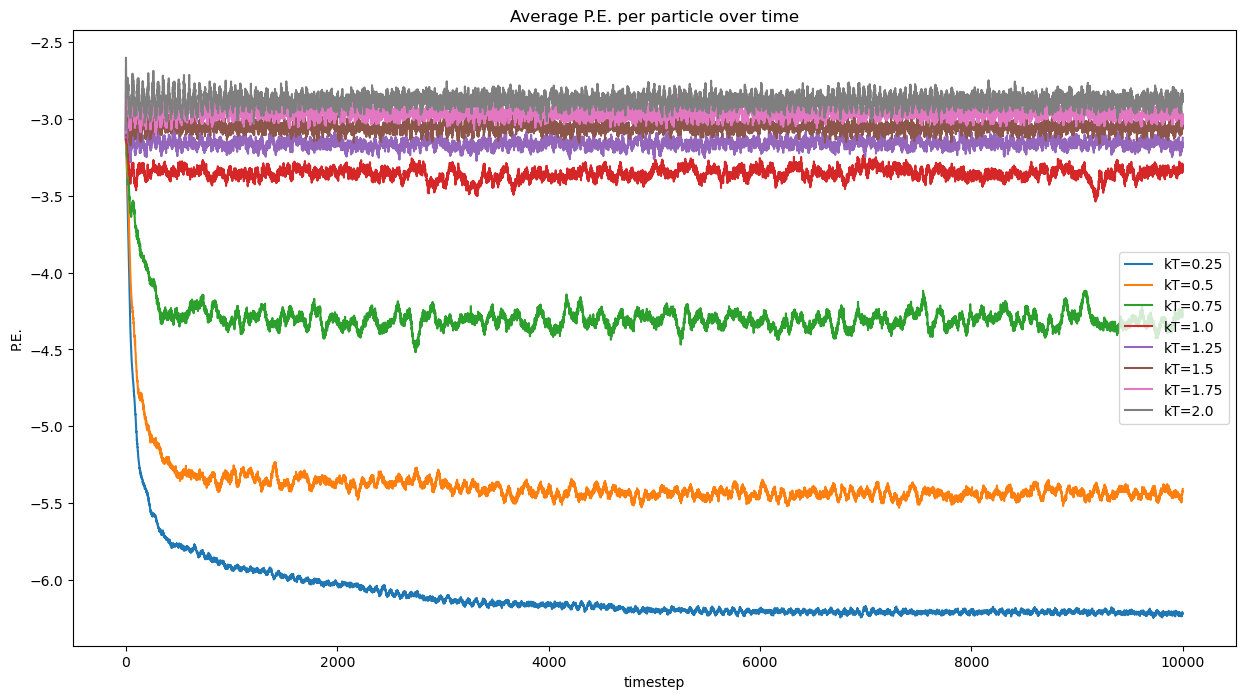

In [9]:
plt.figure(figsize = (15,8))
for kT, energies in potential_energy.items():
    plt.plot(np.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('P.E.')
plt.title('Average P.E. per particle over time')
plt.legend()

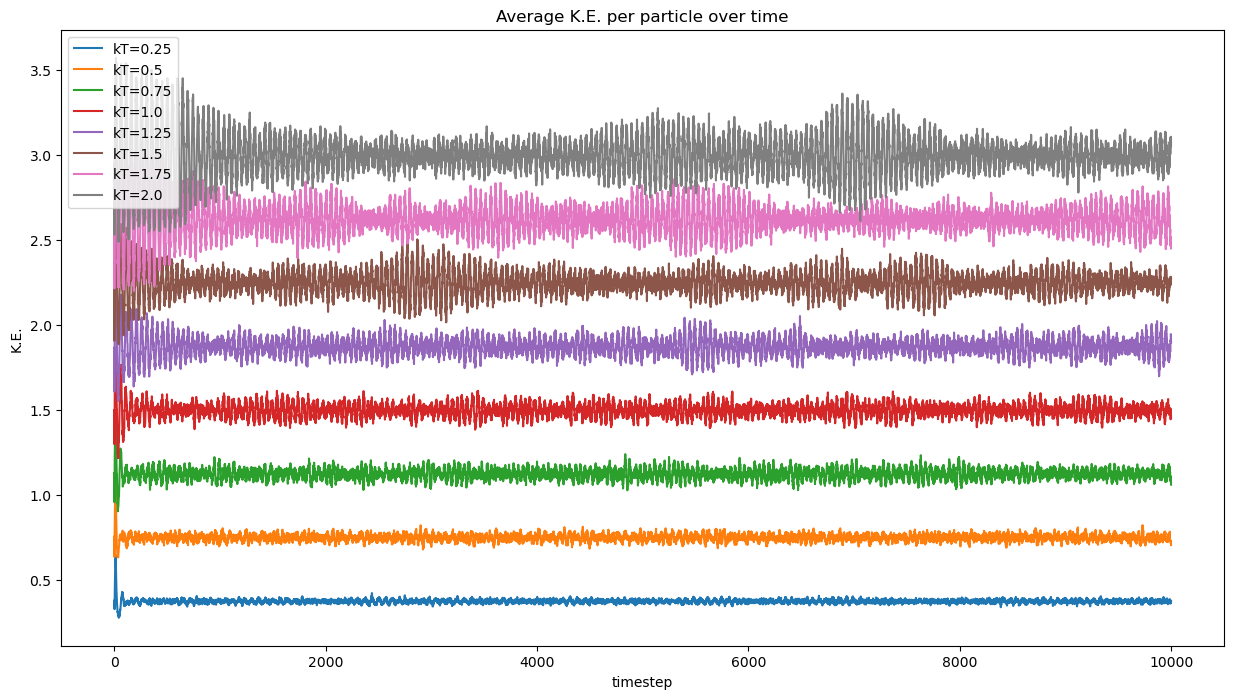

In [10]:
plt.figure(figsize = (15,8))
for kT, energies in kinetic_energy.items():
    plt.plot(np.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('K.E.')
plt.title('Average K.E. per particle over time')
plt.legend()

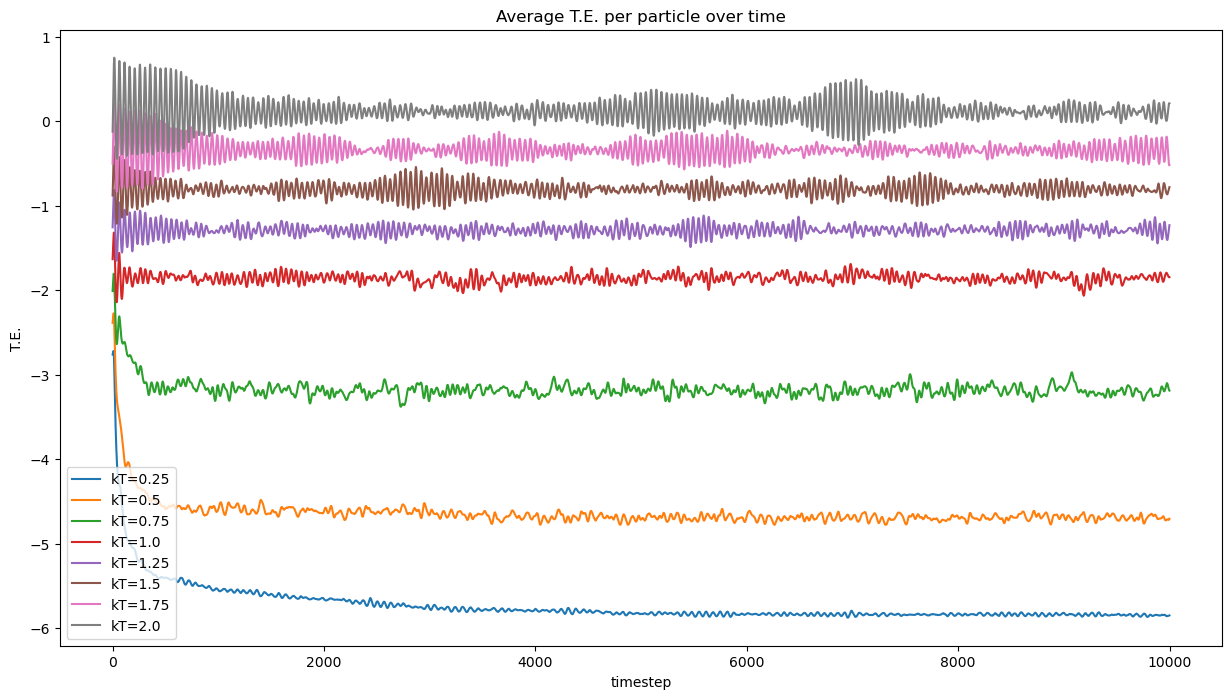

In [11]:
plt.figure(figsize = (15,8))
for kT, energies in total_energy.items():
    plt.plot(np.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('T.E.')
plt.title('Average T.E. per particle over time')
plt.legend()

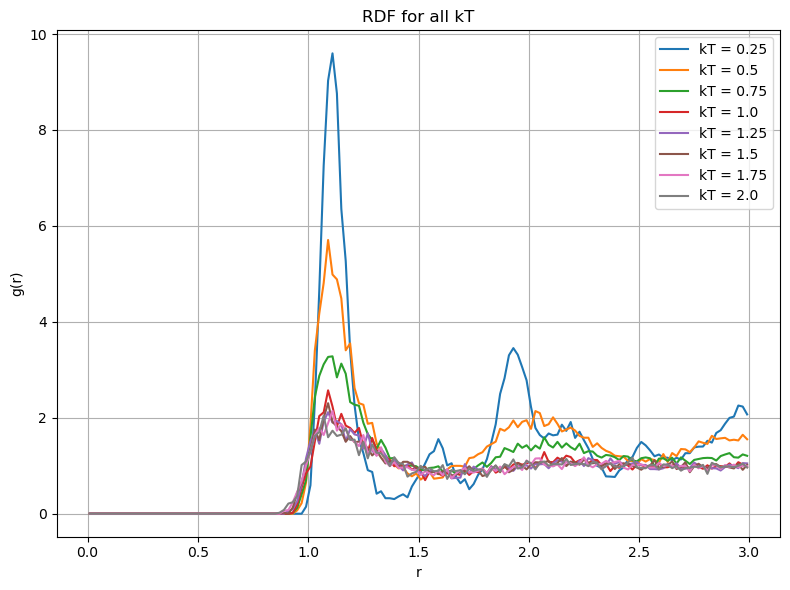

In [12]:
plt.figure(figsize=(8, 6))
for kT in kTs:
    snapshot = snapshots[f"{kT}"] 
    r, g_r = rdf(snapshot, r_max=3.0, bin_width=0.02)
    plt.plot(r, g_r, label=f"kT = {kT}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF for all kT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

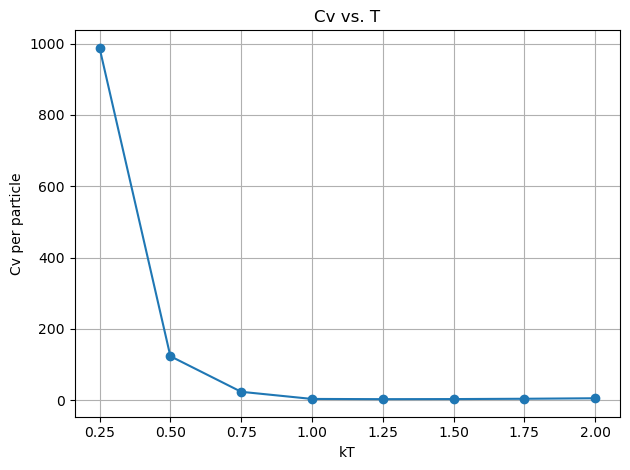

In [13]:
plt.plot(kTs, [heat_capacities[f"{kT}"] for kT in kTs], marker='o')
plt.xlabel("kT")
plt.ylabel("Cv per particle")
plt.title("Cv vs. T")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
del simulation

In [15]:
potential_energy = {}
kinetic_energy = {}
total_energy = {}
snapshots = {}
heat_capacities = {}
dt = 0.005
epsilon = 1.0
sigma = 1.0
starting_density = 0.5
kT = 0.5
Ns = [10,12,15,18,20]
device = hoomd.device.CPU()
seed = np.random.randint(1,1e4)

for n in Ns:
  print(n)
  potential_energy[f"{n}"] = []
  kinetic_energy[f"{n}"] = []
  total_energy[f"{n}"] = []
  snapshots[f"{n}"] = []
  heat_capacities[f"{n}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)

  ##a is the spacing between particles
  a = 1/(starting_density**(1/3.0))
  ##We want a number of particles N in our system.
  ##Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
  num_replicas = n
  N_particles = num_replicas**3
  grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
  box_length = grid_particles[0].Lx

  frame = gsd.hoomd.Frame()
  frame.particles.N = N_particles
  frame.particles.position = grid_particles[1]
  frame.configuration.box = [box_length,box_length,box_length,0,0,0]

  ##Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
  ##in a coarse-grained simulation we can give them a simple name like A
  frame.particles.typeid = [0]*N_particles
  frame.particles.types = ['A']

  ##Finally, save our initial state:
  with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
      f.append(frame)

  simulation.create_state_from_gsd(filename='initial_state.gsd')

  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(), kT = kT , tau = dt*100)
  integrator.methods.append(nvt)

  cell = hoomd.md.nlist.Cell(buffer=0.4)

  ##Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma

  integrator.forces.append(lj)
  simulation.operations.integrator = integrator

  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(thermodynamic_properties, quantities=['potential_energy', 'kinetic_energy'])
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e3)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
      simulation.run(10)
      potential_energy[f"{n}"].append(thermodynamic_properties.potential_energy)
      kinetic_energy[f"{n}"].append(thermodynamic_properties.kinetic_energy)
      total_energy[f"{n}"].append(thermodynamic_properties.kinetic_energy + thermodynamic_properties.potential_energy)
  snapshots[f"{n}"] = simulation.state.get_snapshot()
  Cv_per_particle = heat_cap(total_energy[f"{n}"], kT, N_particles)
  heat_capacities[f"{n}"] = Cv_per_particle
  nsamples, dt_index = autocorr1D(potential_energy[f"{n}"])
  dt_real = dt * 10  ## you're sampling energy every run(10)
    
  tau_relax = relaxation_time_from_acf(potential_energy[f"{n}"], dt_real)
    
  print(f"N = {n:.2f} | Decorrelation time ≈ {dt_index * dt_real:.3f} time units")
  print(f"N = {n:.2f} | Estimated independent samples: {nsamples}")
  print(f"N = {n:.2f} | Relaxation time ≈ {tau_relax:.3f} time units")

10
Simulation.timestep  Simulation.tps 
       1000            1974.98354   
       2000            3217.73329   
       3000            3194.88818   
       4000            1740.81238   
       5000            1673.17345   
       6000            2981.11958   
       7000            1708.75261   
       8000            1524.39024   
       9000            1662.97118   
       10000           1672.55157   
       11000           2998.00133   
       12000           1659.90409   
       13000           1569.03766   
       14000           1707.13202   
       15000           1696.83258   
       16000           2624.67192   
       17000           2987.05609   
       18000           1667.90215   
       19000           1683.50168   
       20000           1707.13202   
       21000           1407.34949   
       22000           1656.84831   
       23000           1675.97765   
       24000           2675.38644   
       25000           2902.28958   
       26000           1706.48464  

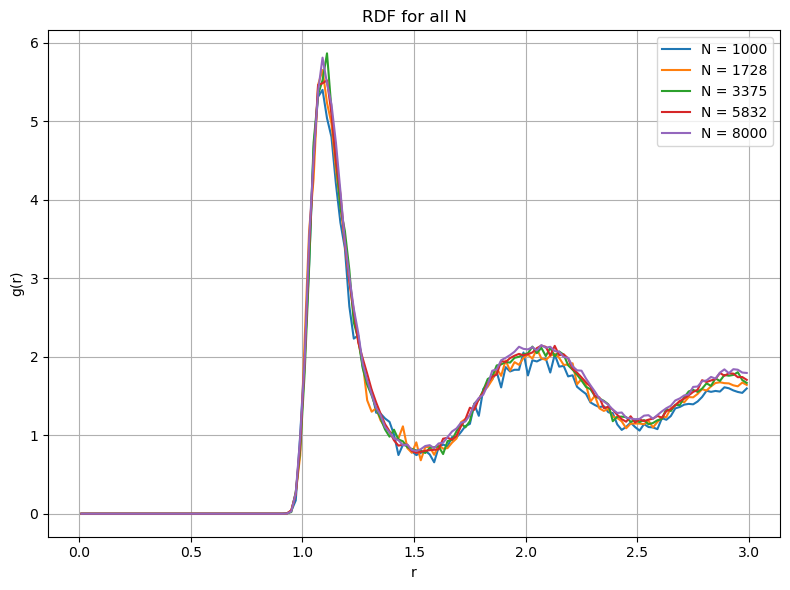

In [16]:
plt.figure(figsize=(8, 6))
for n in Ns:
    snapshot = snapshots[f"{n}"] 
    r, g_r = rdf(snapshot, r_max=3.0, bin_width=0.02)
    N1 = int(n)**3
    plt.plot(r, g_r, label=f"N = {N1}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF for all N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

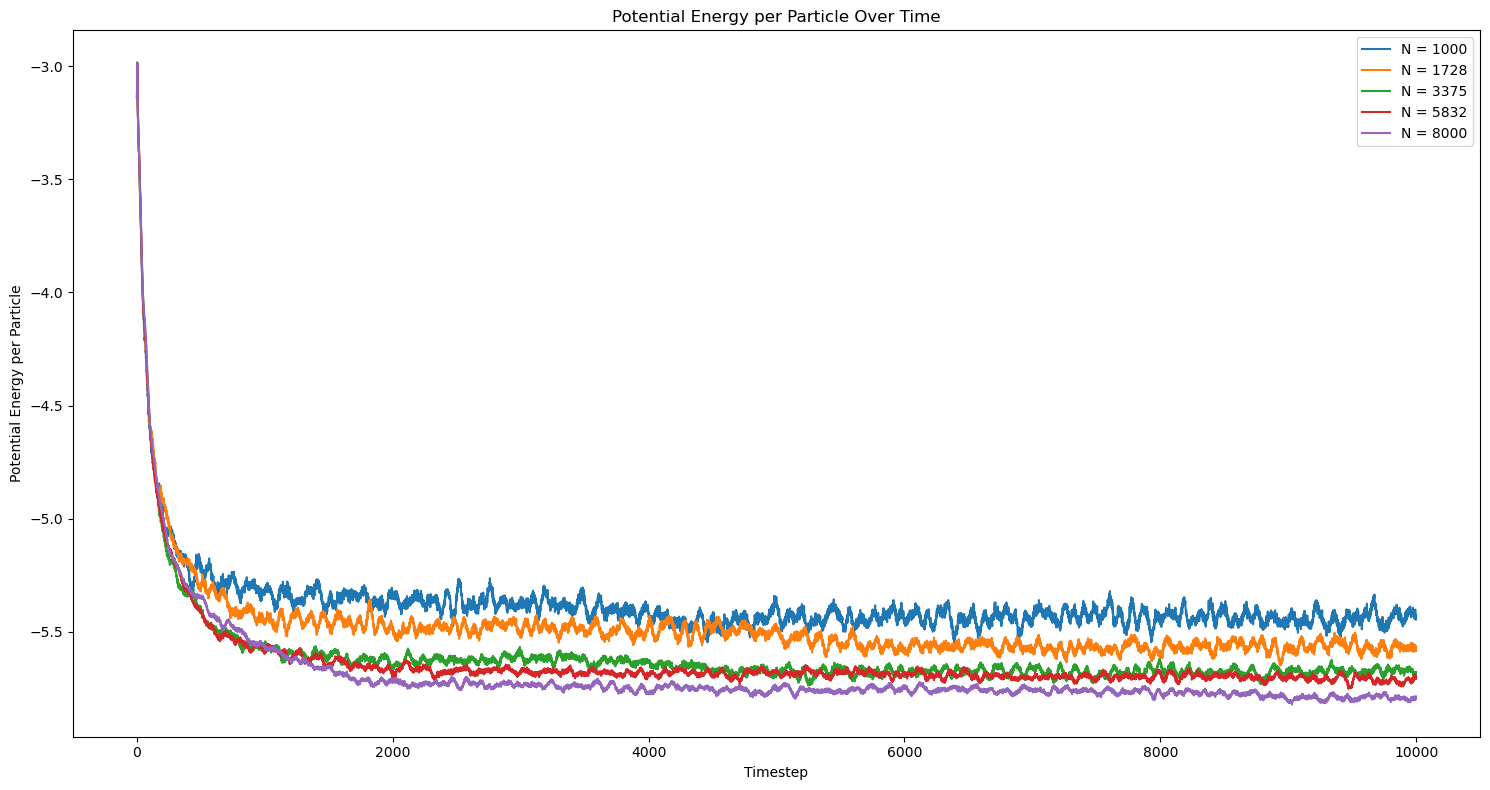

In [17]:
plt.figure(figsize=(15, 8))

for N, energies in potential_energy.items():
    energies = np.array(energies)  
    N_particles = int(N)**3        
    avg_per_particle = energies / N_particles
    N = int(N)**3
    plt.plot(avg_per_particle, label=f'N = {N}')

plt.xlabel('Timestep')
plt.ylabel('Potential Energy per Particle')
plt.title('Potential Energy per Particle Over Time')
plt.legend()
plt.tight_layout()
plt.show()

-5.436348850600409
-5.56319089055739
-5.677141937386261
-5.69721257427811
-5.768464747187044


Text(0, 0.5, 'Potential Energy average per particle')

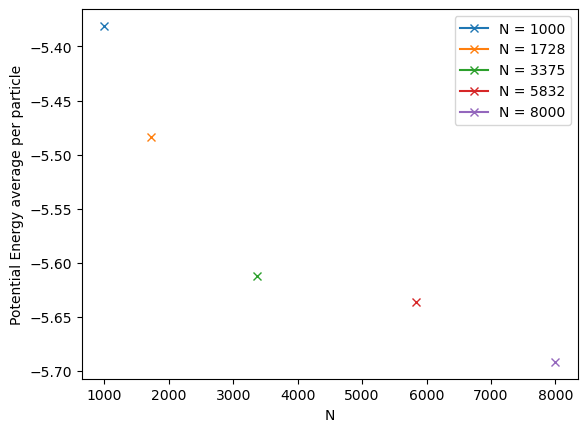

In [18]:
for N, e in potential_energy.items():
  print(np.mean(e[5000:])/(int(N)**3))
  N1 = int(N)**3
  plt.plot(int(N)**3,np.mean(e[0:])/(int(N)**3), marker = 'x', label = f'N = {N1}')
plt.xlabel('N')
plt.legend()
plt.ylabel('Potential Energy average per particle')

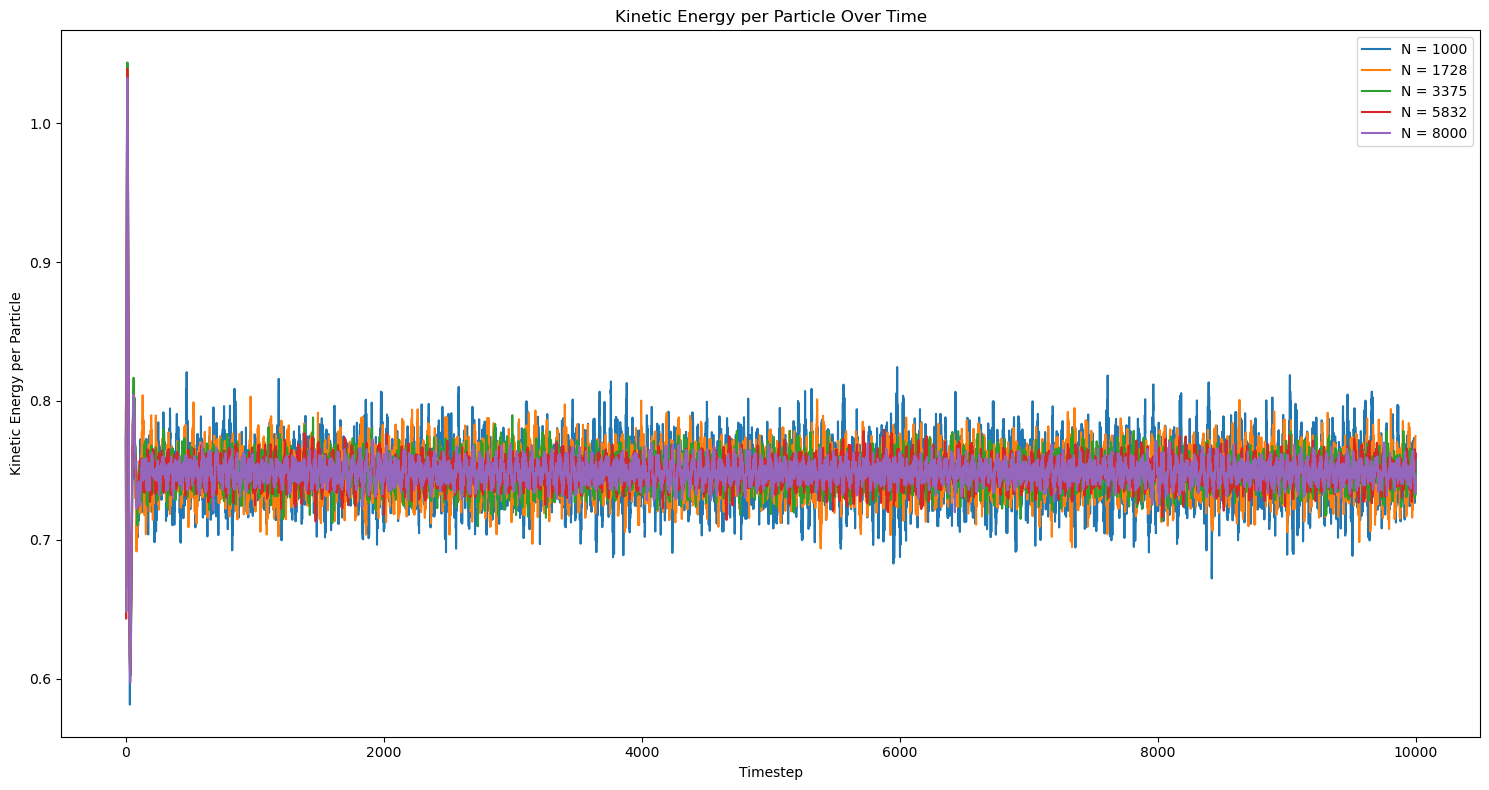

In [19]:
plt.figure(figsize=(15, 8))

for N, energies in kinetic_energy.items():
    energies = np.array(energies)  
    N_particles = int(N)**3        
    avg_per_particle = energies / N_particles
    N = int(N)**3
    plt.plot(avg_per_particle, label=f'N = {N}')

plt.xlabel('Timestep')
plt.ylabel('Kinetic Energy per Particle')
plt.title('Kinetic Energy per Particle Over Time')
plt.legend()
plt.tight_layout()
plt.show()

0.7482216342821826
0.7484833996949872
0.7486345484219428
0.7487773613088675
0.748757135581835


Text(0, 0.5, 'Kinetic Energy average per particle')

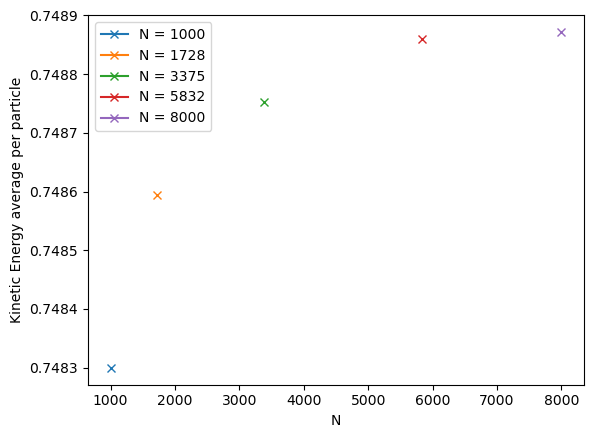

In [20]:
for N, e in kinetic_energy.items():
  print(np.mean(e[5000:])/(int(N)**3))
  N1 = int(N)**3
  plt.plot(int(N)**3,np.mean(e[0:])/(int(N)**3), marker = 'x', label = f'N = {N1}')
plt.xlabel('N')
plt.legend()
plt.ylabel('Kinetic Energy average per particle')

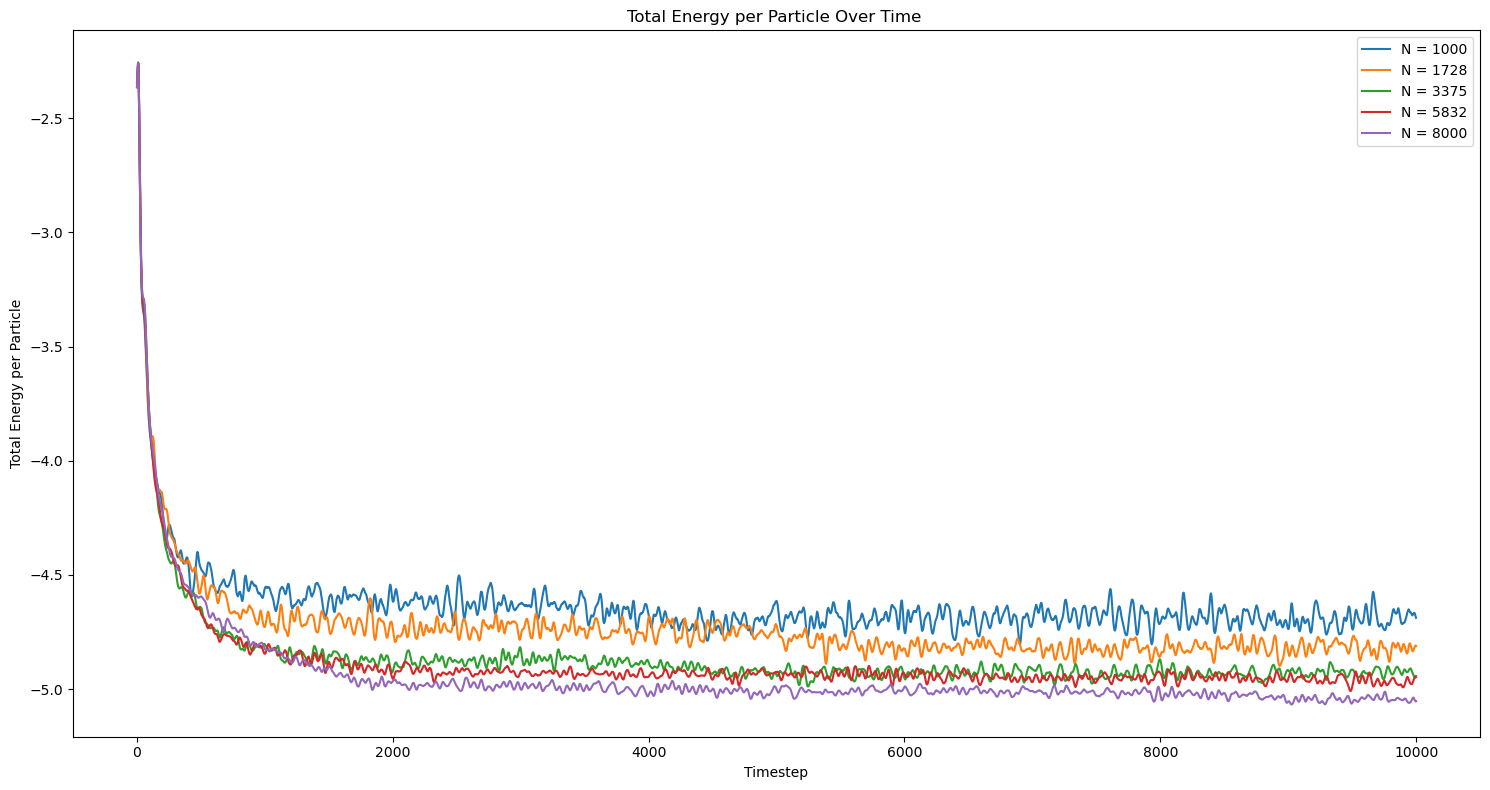

In [21]:
plt.figure(figsize=(15, 8))

for N, energies in total_energy.items():
    energies = np.array(energies)  
    N_particles = int(N)**3        
    avg_per_particle = energies / N_particles
    N = int(N)**3
    plt.plot(avg_per_particle, label=f'N = {N}')

plt.xlabel('Timestep')
plt.ylabel('Total Energy per Particle')
plt.title('Total Energy per Particle Over Time ')
plt.legend()
plt.tight_layout()
plt.show()

-4.688127216318228
-4.814707490862403
-4.9285073889643165
-4.948435212969241
-5.0197076116052095


Text(0, 0.5, 'Total Energy average per particle')

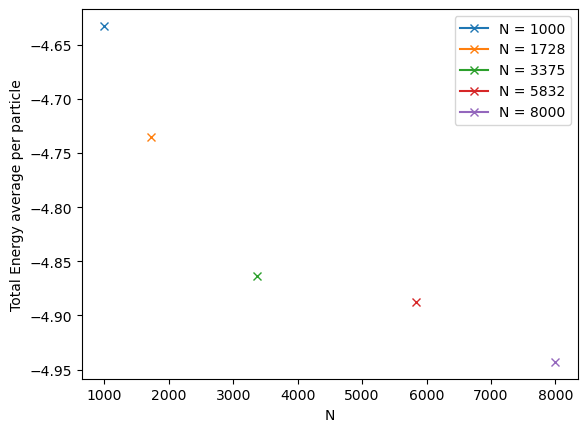

In [22]:
for N, e in total_energy.items():
  print(np.mean(e[5000:])/(int(N)**3))
  N1 = int(N)**3
  plt.plot(int(N)**3,np.mean(e[0:])/(int(N)**3), marker = 'x', label = f'N = {N1}')
plt.xlabel('N')
plt.legend()
plt.ylabel('Total Energy average per particle')

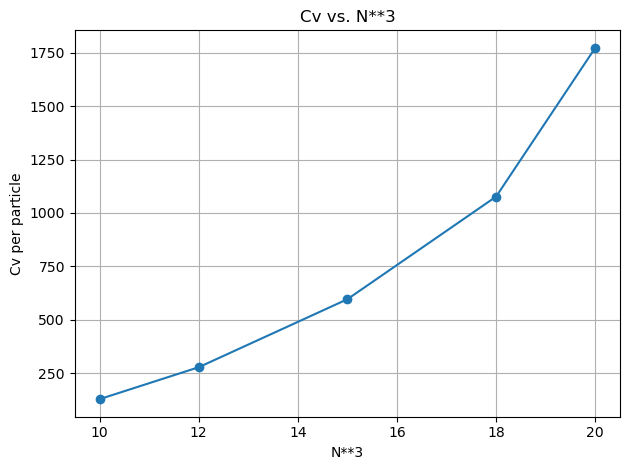

In [23]:
plt.plot(Ns, [heat_capacities[f"{n}"] for n in Ns], marker='o')
plt.xlabel("N**3")
plt.ylabel("Cv per particle")
plt.title("Cv vs. N**3")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
del simulation

In [38]:
potential_energy = {}
kinetic_energy = {}
total_energy = {}
snapshots = {}
heat_capacities = {}
pressures = {}
dt = 0.005
epsilon = 0
sigma = 0
starting_density = 0.5
kTs = [0.25, 0.50, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
device = hoomd.device.CPU()
seed = np.random.randint(1,1e4)

for kT in kTs:
  print(kT)
  potential_energy[f"{kT}"] = []
  kinetic_energy[f"{kT}"] = []
  total_energy[f"{kT}"] = []
  snapshots[f"{kT}"] = []
  heat_capacities[f"{kT}"] = []
  pressures[f"{kT}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)

  ##a is the spacing between particles
  a = 1/(starting_density**(1/3.0))
  ##We want a number of particles N in our system.
  ##Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
  num_replicas = 10
  N_particles = num_replicas**3
  grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
  box_length = grid_particles[0].Lx

  frame = gsd.hoomd.Frame()
  frame.particles.N = N_particles
  frame.particles.position = grid_particles[1]
  frame.configuration.box = [box_length,box_length,box_length,0,0,0]

  ##Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
  ##in a coarse-grained simulation we can give them a simple name like A
  frame.particles.typeid = [0]*N_particles
  frame.particles.types = ['A']

  ##Finally, save our initial state:
  with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
      f.append(frame)

  simulation.create_state_from_gsd(filename='initial_state.gsd')

  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(), kT = kT , tau = dt*100)
  integrator.methods.append(nvt)

  cell = hoomd.md.nlist.Cell(buffer=0.4)

  ##Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma

  integrator.forces.append(lj)
  simulation.operations.integrator = integrator

  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(thermodynamic_properties, quantities=['potential_energy', 'kinetic_energy'])
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e3)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
      simulation.run(10)
      potential_energy[f"{kT}"].append(thermodynamic_properties.potential_energy)
      kinetic_energy[f"{kT}"].append(thermodynamic_properties.kinetic_energy)
      total_energy[f"{kT}"].append(thermodynamic_properties.kinetic_energy + thermodynamic_properties.potential_energy)
  snapshots[f"{kT}"] = simulation.state.get_snapshot()
  Cv_per_particle = (3/2)
  p = (N_particles*kT)/(box_length**3)
  pressures[f"{kT}"].append(p)
  heat_capacities[f"{kT}"] = Cv_per_particle

0.25
Simulation.timestep  Simulation.tps 
       1000           29220.77922   
       2000           19067.79661   
       3000           28125.00000   
       4000           20270.27027   
       5000           26946.10778   
       6000           20000.00000   
       7000           18907.56303   
       8000           20224.71910   
       9000           27190.33233   
       10000          21126.76056   
       11000          27190.33233   
       12000          16216.21622   
       13000          28571.42857   
       14000          19823.78855   
       15000          27950.31056   
       16000          20737.32719   
       17000          26865.67164   
       18000          21428.57143   
       19000          28938.90675   
       20000          19230.76923   
       21000          29220.77922   
       22000          19955.65410   
       23000          27692.30769   
       24000          20089.28571   
       25000          28481.01266   
       26000          20833.33333

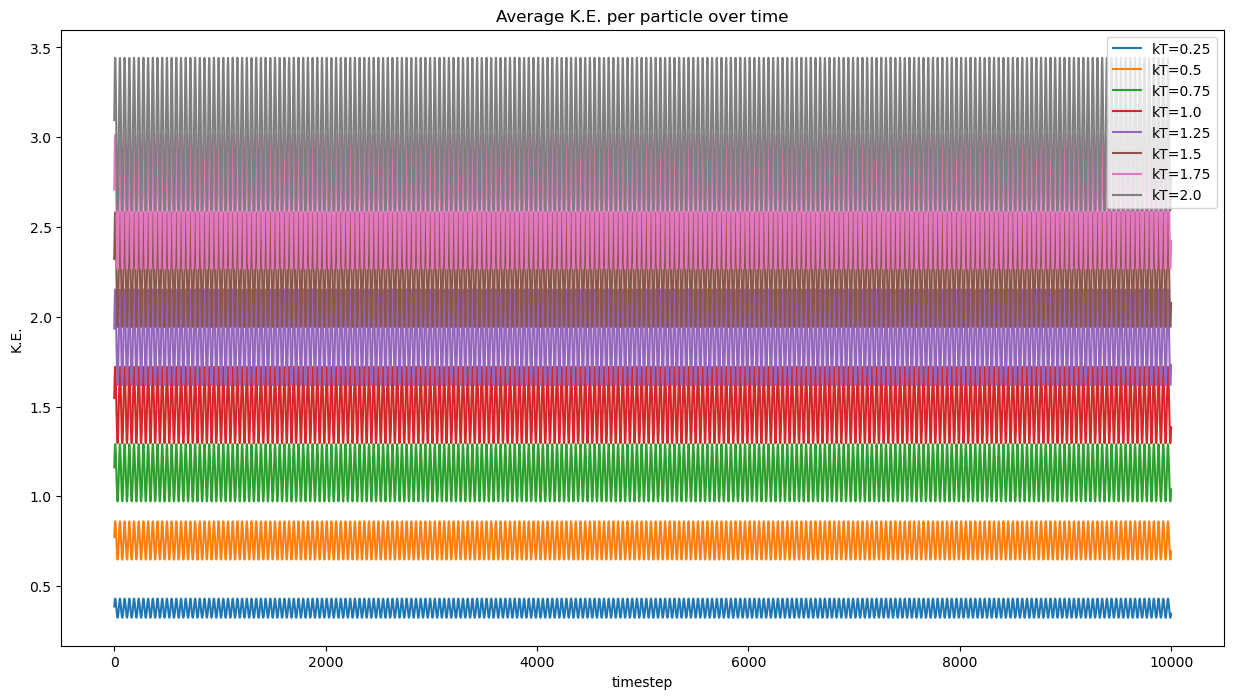

In [30]:
plt.figure(figsize = (15,8))
for kT, energies in kinetic_energy.items():
    plt.plot(np.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('K.E.')
plt.title('Average K.E. per particle over time')
plt.legend()

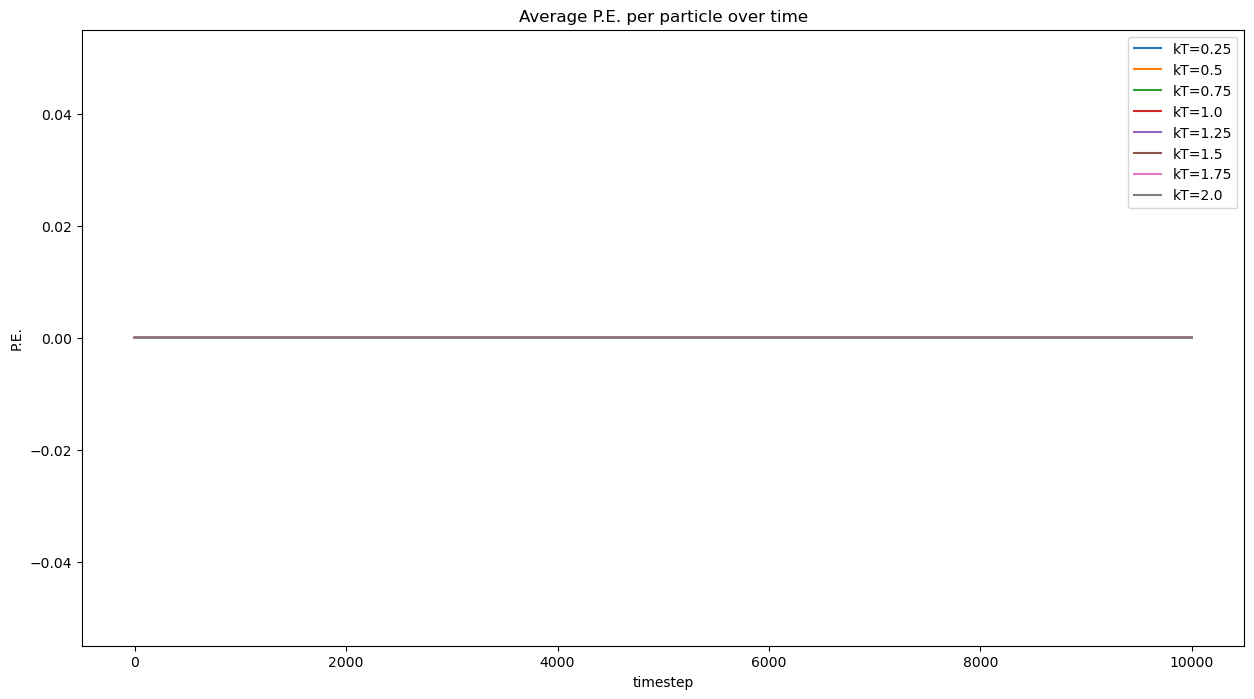

In [31]:
plt.figure(figsize = (15,8))
for kT, energies in potential_energy.items():
    plt.plot(np.array(energies[0:])/N_particles, label=f'kT={kT}')
plt.xlabel('timestep')
plt.ylabel('P.E.')
plt.title('Average P.E. per particle over time')
plt.legend()

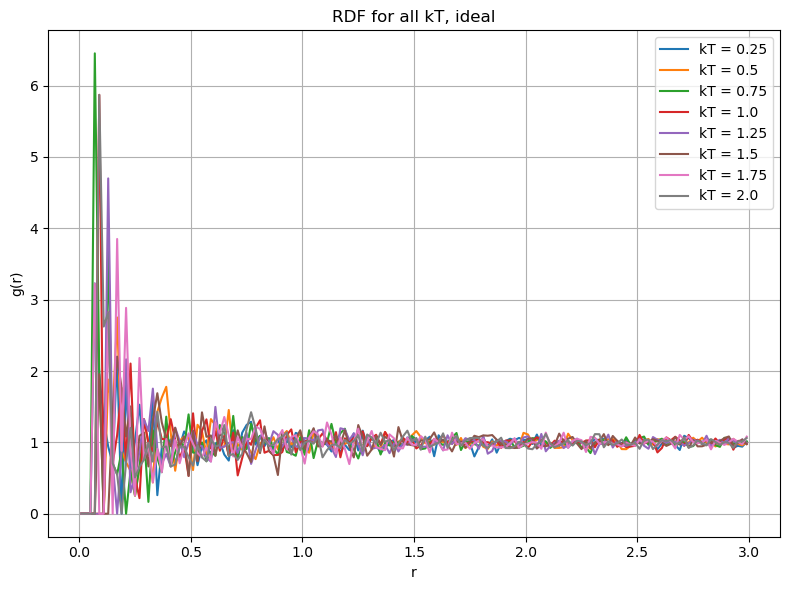

In [26]:
plt.figure(figsize=(8, 6))
for kT in kTs:
    snapshot = snapshots[f"{kT}"] 
    r, g_r = rdf(snapshot, r_max=3.0, bin_width=0.02)
    plt.plot(r, g_r, label=f"kT = {kT}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF for all kT, ideal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

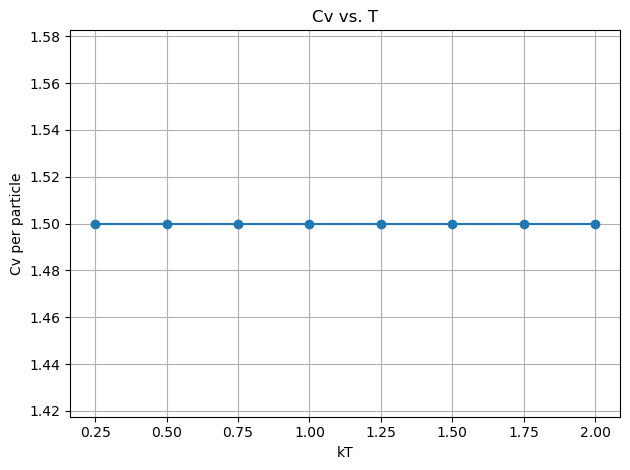

In [39]:
plt.plot(kTs, [heat_capacities[f"{kT}"] for kT in kTs], marker='o')
plt.xlabel("kT")
plt.ylabel("Cv per particle")
plt.title("Cv vs. T")
plt.grid(True)
plt.tight_layout()
plt.show()

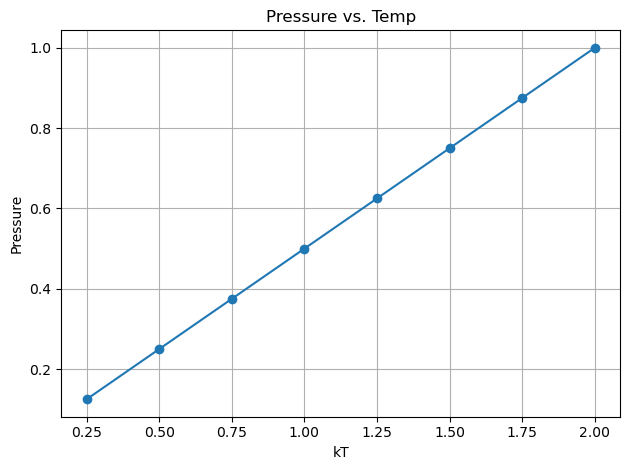

In [28]:
plt.plot(kTs, [pressures[f"{kT}"] for kT in kTs], marker='o')
plt.xlabel("kT")
plt.ylabel("Pressure")
plt.title("Pressure vs. Temp")
plt.grid(True)
plt.tight_layout()
plt.show()